<h4>Import required libraries</h4>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

<h3>Initialization</h3>

Defines the function that initializes the position of the particles and their momenta.
The particles are placed in a fcc lattice and are given momenta that are picked from a maxwell-boltzmann distribution.

In [2]:
def initializeRP(N,M,T,a):
    
    # Initialize positions, r
    r = np.zeros((N,3))
    unit_cell = np.array([[0.0, 0.0, 0.0],[0.5*a, 0.5*a, 0.0],[0.5*a, 0.0, 0.5*a],[0.0, 0.5*a, 0.5*a]]) # Position of atoms on the unit cell
    
    # Place particles on the lattice
    n = 0                                             # Number of particles placed so far
    for i in range(M):
        for j in range(M):
            for k in range(M):
                for l in range(4):
                    if n<N:
                        r[n,:] = unit_cell[l,:] + [i*a, j*a, k*a]
                        n += 1
    
    # Initialize momenta of particles, p
    p = np.random.normal(0, (kb*T*mass)**(1/2), (N,3))
    
    # Correct for drift of center of mass
    vCM = np.sum(p,0)/(N*mass)                        # Velocity of center of mass
    p -= -vCM*mass
    
    # Rescale the velocity to agree with the temperature
    p = p * (((N-1)*3*kb*T)/ (np.sum(p*p)/mass))**(1/2)
    
    return r, p

<h3>Force Calculation</h3>

Defines the function that is used to calculate the force each particle caused by the two-particle interactions. The interactions are governed by a Lennard-Jones potential.
Additionally the potential energy of the gas is calculated.

In [3]:
@jit
def computeForce(r,N,L_box,compPressure=False):
    force = np.zeros((N,3))
    r_cutsqrd = r_cut*r_cut
    potential = 0
    virialCoeff = 0
    for i in range(N-1):
        for j in range((i+1),N):
            
            rij_x = r[i,0]-r[j,0]
            rij_y = r[i,1]-r[j,1]
            rij_z = r[i,2]-r[j,2]
            
            rij_x -= np.rint(rij_x/L_box)*L_box
            rij_y -= np.rint(rij_y/L_box)*L_box
            rij_z -= np.rint(rij_z/L_box)*L_box
            
            r_sqrd = rij_x*rij_x + rij_y*rij_y + rij_z*rij_z
            
            if (r_sqrd < r_cutsqrd or noCutoff):
                F = 12*((1/r_sqrd)**7 -(1/r_sqrd)**4)
                potential += (1/r_sqrd)**6 -2*(1/r_sqrd)**3
                
                force[i,0] += rij_x*F
                force[j,0] -= rij_x*F
                
                force[i,1] += rij_y*F
                force[j,1] -= rij_y*F
                
                force[i,2] += rij_z*F
                force[j,2] -= rij_z*F
                
                if compPressure:
                    virialCoeff += r_sqrd**(1/2) * F
                    
    if compPressure:
        return force, potential, virialCoeff
                    
                
    return force, potential

<h3>Correlation function</h3>

$$ g(r)=\frac{2V}{N(N-1)}\left(\frac{\langle np(r)\rangle }{4\pi r^2 \Delta r}\right) \simeq \frac{\langle np(r) \rangle}{r^2} $$


In [29]:
def Correlation_function(r,nbins):
    rij = np.zeros((N*(N-1))//2)
    count = 0
    
    for i in range(N-1):
        for j in range((i+1),N):
                rij_x = r[i,0]-r[j,0]
                rij_x -= np.rint(rij_x/L_box)*L_box
                rij_y = r[i,1]-r[j,1]
                rij_y -= np.rint(rij_y/L_box)*L_box
                rij_z = r[i,2]-r[j,2]
                rij_z -= np.rint(rij_z/L_box)*L_box
                rij[count] = (rij_x*rij_x + rij_y*rij_y + rij_z*rij_z)**(1/2)
                count = count+1
    
    #Order distances in histogram
    Hist = np.histogram(rij, bins=nbins, range=[0, L_box*.5])
    Hist_y = Hist[0]                                                 #height bins
    Hist_x = Hist[1]                                                 #x-values hist
    Delta_x = (Hist_x[1]-Hist_x[0])                                  #bin width
    Center = np.linspace(Delta_x/2, Hist_x[-1]-Delta_x, len(Hist_y)) #Center of bins
    
    
    #Calculate correlation function
    Cor_func = 2*L_box**3*(N*(N-1))**(-1)*Hist_y/(4*math.pi*(Center)**2*Delta_x)
    
    plt.plot(Center, Cor_func)
    plt.title('Correlation Function for T= after steps')
    plt.xlabel('r')
    plt.ylabel('g(r)')
    
    return Cor_func, Center

<h3>Heat capacity</h3>

Heat capacity NVT

$$ C_V^{NVT} = \frac{var \left( E_{tot} \right)}{T^2} $$

In [5]:
def Heat_capacity_NVT(T,var_E_tot):
    
    heat_cap_NVT = var_E_tot/(T)**2
    return heat_cap_NVT

Heat capacity NVE

 $$ C_V^{NVE} = \left( \frac{2}{3 N} - \frac{var \left( E_{kin} \right)}{ \langle E_{kin}\rangle^2} \right)^{-1} $$

In [6]:
def Heat_capacity_NVE(var_E_kin,exp_E_kin,N):
    T_vec = np.linspace(0.1,3,20)
    heat_cap_NVE_vec = np.zeros(len(T_vec))
    
    for i in range(len(T_vec)):
        T = T_vec[i]
        #heat_cap_NVE = (2*N)/3-4*var_E_kin/(9*T**2)
        heat_cap_NVE = (2/(3*N)-var_E_kin/(exp_E_kin**2))**(-1)
        heat_cap_NVE_vec[i] = heat_cap_NVE
    
    plt.plot(T_vec, heat_cap_NVE_vec)
    plt.title('Heat capacity in NVE ensemble')
    plt.xlabel('T')
    plt.ylabel('C_v')
    
    
    return heat_cap_NVE_vec


<h3>Calculating Standard Deviation of Physical Quantity</h3>

Split in blocks, find mean of separate blocks. Use these blocks to find standard deviation.

In [7]:
def comp_std_mean(data, correlationtime):
    data_parts = np.reshape(data,(correlationtime,(len(data)-len(data)%correlationtime)/correlationtime))
    parts = np.mean(data_parts,1)
    
    # mean  of data
    mean_data = np.mean(parts)
    
    # standard deviation
    std_data = np.std(parts)
    
    return mean_data, std_data

<h3>Simulation</h3>

Defines the function that is used to run a simulation.

In [8]:
def simulate(N,M,T,a,L_box,dt,nsteps,energyPlot=False,compMomentum=False,constantT=False,compPressure=False,returnEnergy=False):
    
    E_kin = np.zeros(nsteps)
    E_pot = np.zeros(nsteps)
    
    [r, p] = initializeRP(N,M,T,a)
    r0 = r
    p0 = p
    
    pressureCoeff = np.zeros(nsteps)
    temperature = np.zeros(nsteps)
    
    force = computeForce(r,N,L_box)[0]
    
    for i in range(nsteps):
        
        # Verlet applied to position of particle and first part of momentum
        p += (dt/2)*force
        r += p*dt
        r = r % L_box #Places particles back into box
        
        # Compute new force
        if compPressure:
            force, E_pot[i], pressureCoeff[i] = computeForce(r,N,L_box,compPressure=True)
        else:
            force, E_pot[i] = computeForce(r,N,L_box)
        
        # Second part of momentum, using Verlet
        p += 0.5*force*dt
        
        # For a gas which is kept at a constant temperature
        if constantT:
            p = p * (((N-1)*3*kb*T)/ np.sum(p*p))**(1/2)
        
        E_kin[i] = 0.5*np.sum(p*p)
        
    if energyPlot:
        plt.figure()
        plt.plot(range(nsteps),(E_kin+E_pot), label='Total Energy')
        plt.plot(range(nsteps),E_pot, label='Potential Energy')
        plt.plot(range(nsteps),E_kin, label='Kinetic Energy')
        plt.legend(loc='upper right')
        plt.show()
    
    if compMomentum:
        print('Initial momentum:', np.sum(p0,0)/N)
        print('Final momentum:', np.sum(p,0)/N)
        print('Difference in momentum:', np.sum(p0,0)/N-np.sum(p,0)/N )
        
    if compPressure:
        return r, p, pressureCoeff
    
    if returnEnergy:
        E_tot = E_kin + E_pot
        return r, p, E_tot, E_kin
        
    return r, p

<h1>Several simulations</h1>

<h3>Sim 1: Microcanonical ensemble</h3>

A simulation of a microcanonical ensemble. The number of particles, the volume, and the energy are kept constant.

<h4>Constants and initial parameters </h4>

In [8]:
# Physical parameters in natural units
mass = 1          # Mass of an Argon atom
sigma = 1         # Position of potential well; U(sigma) = -epsilon
epsilon = 1       # Depth of potential well.
kb = 1            # Boltzmann constant
T = 1             # Temperature. T = (temperature in Kelvin) / 119.8 

# Units of time
tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time
dt = 4e-3 * tau                            # Size of time step ~ 1e-14 s
nsteps = 2000                              # Number of timesteps

# Cut-off distance or switch
r_cut = 3*sigma
noCutoff = True

#System size
N = 256         # Number of particles

#Choose a or density:
# a:
a = 1.5*sigma          # Unit cell size
density = 4/(a**3)     # Density, number of atoms / sigma^3
# density:

""" density = 1            # Density, number of atoms / sigma^3
a = (4/density)**(1/3) # Unit cell size """

# Number of unit cells
M = 1                  # Number of unit cell in one direction
while (4*(M**3)) < N:
    M += 1
L_box = M*a            # Length of sides of box
if r_cut > L_box:
    r_cut = 2*L_box/(2**(1/3))

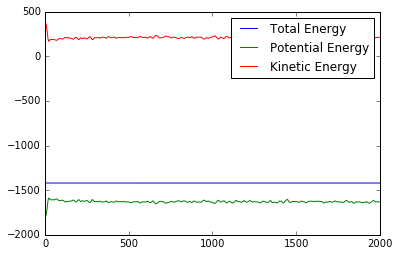

In [9]:
[r, p] = simulate(N,M,T,a,L_box,dt,nsteps,compPressure=False,energyPlot=True)

The system behaves as expected, for different values of $a$ there is a different ratio between total kinetic and total potential energy as expected. The total energy remains constant as desired and after approximately 200 timesteps the system is in equilibrium.<br>
<br>
The fluctuations in total energy are on the order of: ...... <br>
The fluctuations in temperature behave as $1/\sqrt{N}$ as predicted by statistical mechanics.

<h3>Sim 2: Canonical Ensemble</h3>

A simulation of a canonical ensemble. The number of particles, the volume, and the temperature are kept constant.

<h4>Constants and initial parameters </h4>

In [10]:
# Physical parameters in natural units
mass = 1          # Mass of an Argon atom
sigma = 1         # Position of potential well; U(sigma) = -epsilon
epsilon = 1       # Depth of potential well.
kb = 1            # Boltzmann constant
T = 1             # Temperature. T = (temperature in Kelvin) / 119.8 

# Units of time
tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time
dt = 4e-3 * tau                            # Size of time step ~ 1e-14 s
nsteps = 2000                              # Number of timesteps

# Cut-off distance or switch
r_cut = 3*sigma
noCutoff = True

#System size
N = 256         # Number of particles

#Choose a or density:
# a:
a = 1.5*sigma          # Unit cell size
density = 4/(a**3)     # Density, number of atoms / sigma^3
# density:

""" density = 1            # Density, number of atoms / sigma^3
a = (4/density)**(1/3) # Unit cell size """

# Number of unit cells
M = 1                  # Number of unit cell in one direction
while (4*(M**3)) < N:
    M += 1
L_box = M*a            # Length of sides of box
if r_cut > L_box:
    r_cut = 2*L_box/(2**(1/3))

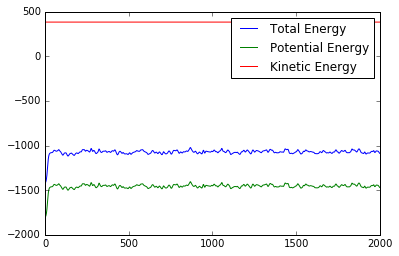

Initial momentum: [-0.196213    0.0469244   0.00533967]
Final momentum: [-0.31074989  0.07431593  0.00845664]
Difference in momentum: [ 0.11453689 -0.02739153 -0.00311697]


In [11]:
[r, p] = simulate(N,M,T,a,L_box,dt,nsteps,energyPlot=True,compMomentum=True,constantT=True)

Blabla interesting results...............

<h3>Sim 3: The correlation function</h3>

-

In [34]:
# Physical parameters in natural units
mass = 1          # Mass of an Argon atom
sigma = 1         # Position of potential well; U(sigma) = -epsilon
epsilon = 1       # Depth of potential well.
kb = 1            # Boltzmann constant
T = 1             # Temperature. T = (temperature in Kelvin) / 119.8 

# Units of time
tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time
dt = 4e-3 * tau                            # Size of time step ~ 1e-14 s
nsteps = 1000                              # Number of timesteps

#System size
N = 6912         # Number of particles

#Choose a or density:
# a:
a = 2**(1/2)*sigma          # Unit cell size
density = 4/(a**3)     # Density, number of atoms / sigma^3
# density:

""" density = 1            # Density, number of atoms / sigma^3
a = (4/density)**(1/3) # Unit cell size """

# Number of unit cells
M = 1                  # Number of unit cell in one direction
while (4*(M**3)) < N:
    M += 1
L_box = M*a            # Length of sides of box

# Cut-off distance or switch
r_cut = 3*sigma
noCutoff = True
if noCutoff:
    r_cut = 2*L_box/(2**(1/3))

In [35]:
r = simulate(N,M,T,a,L_box,dt,nsteps)[0];
#np.save('.\Data\posCorFunc_N=6912_T=1_a=sqrt(2)', r)

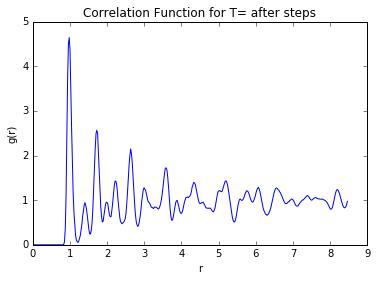

In [38]:
nbins = 400
Correlation_function(r,nbins);
#plt.savefig('.\Figures\CorFunc_N=6912_T=1_a=sqrt(2)_bins=150.png')

<h3>Sim 4: Pressure of a gas</h3>

Using the virial theorem we compute the pressure of the gas.

In [15]:
# Physical parameters in natural units
mass = 1          # Mass of an Argon atom
sigma = 1         # Position of potential well; U(sigma) = -epsilon
epsilon = 1       # Depth of potential well.
kb = 1            # Boltzmann constant
T = 1             # Temperature. T = (temperature in Kelvin) / 119.8 

# Units of time
tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time
dt = 4e-3 * tau                            # Size of time step ~ 1e-14 s
nsteps = 2000                              # Number of timesteps

# Cut-off distance or switch
r_cut = 3*sigma
noCutoff = True

#System size
N = 256         # Number of particles

# Number of unit cells
M = 1                  # Number of unit cell in one direction
while (4*(M**3)) < N:
    M += 1

In [41]:
# Find pressure for multiple densities and temperatures
density_array = [np.linspace(0.3, 1.05, 20), np.linspace(0.3, 1.05, 20), np.linspace(0.3, 1.05, 20)]
T_array = [0.5, 1, 1.5]
neq = 500 # equilibrium point

pressure = [np.zeros([len(density_array[0]), nsteps-neq]), np.zeros([len(density_array[1]), nsteps-neq]), np.zeros([len(density_array[2]), nsteps-neq])]
meanPressure = [np.zeros(len(density_array[0])), np.zeros(len(density_array[1])), np.zeros(len(density_array[2]))]
error = [np.zeros(len(density_array[0])), np.zeros(len(density_array[1])), np.zeros(len(density_array[2]))]

for temp in range(len(T_array)):
    for dens in range(len(density_array[temp])):
        density = density_array[temp][dens]
        
        a = (4/density)**(1/3) # Unit cell size
        L_box = M*a            # Length of sides of box
        r_cut = 2*L_box/(2**(1/3))
        
        pressureCoeff = simulate(N,M,T_array[temp],a,L_box,dt,nsteps,compPressure=True,constantT=True)[2]
        
        pzero = ((N/L_box**3)**2)*epsilon*np.pi*(8/3)*((sigma**12)/(3*r_cut**9)-(sigma**6)/(r_cut**3))
        
        pressure[temp][dens][:] = 3*(N/L_box**3)*kb*T - (1/(3*L_box**3))*pressureCoeff[neq:nsteps] - pzero  
        meanPressure[temp][dens], error[temp][dens] = comp_std_mean(pressure[temp][dens][:], 50)


In [44]:
#Saving data
#np.save('.\Data\meanPressure', meanPressure)
#np.save('.\Data\error', error)  

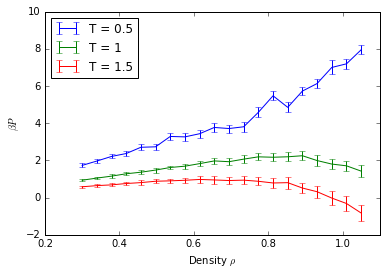

In [45]:
plt.figure()
plt.errorbar(density_array[0],meanPressure[0]/T_array[0], yerr=error[0])
plt.errorbar(density_array[1],meanPressure[1]/T_array[1], yerr=error[1])
plt.errorbar(density_array[2],meanPressure[2]/T_array[2], yerr=error[2])
plt.legend(['T = 0.5', 'T = 1', 'T = 1.5'], loc = 2)
plt.xlabel(r'Density $\rho$')
plt.ylabel(r'$\beta P$')
#plt.savefig('.\Figures\Pressure_vs_Density_n=864.png')
plt.show()

<h3>Sim 5: Heat capacity NVT and NVE</h3>

In [25]:
# Physical parameters in natural units
mass = 1          # Mass of an Argon atom
sigma = 1         # Position of potential well; U(sigma) = -epsilon
epsilon = 1       # Depth of potential well.
kb = 1            # Boltzmann constant
T = 3             # Temperature. T = (temperature in Kelvin) / 119.8 

# Units of time
tau = ((mass/epsilon) * sigma**2) ** (1/2) # Unit of time
dt = 4e-3 * tau                            # Size of time step ~ 1e-14 s
nsteps = 10000                              # Number of timesteps

# Cut-off distance or switch
r_cut = 3*sigma
noCutoff = True

#System size
N = 256         # Number of particles

#Choose a or density:
# a:
a = 2**(1/2)*sigma          # Unit cell size
density = 4/(a**3)     # Density, number of atoms / sigma^3
# density:

""" density = 1            # Density, number of atoms / sigma^3
a = (4/density)**(1/3) # Unit cell size """

# Number of unit cells
M = 1                  # Number of unit cell in one direction
while (4*(M**3)) < N:
    M += 1
L_box = M*a            # Length of sides of box

In [26]:
#calc heat cap
[E_tot, E_kin] = simulate(N,M,T,a,L_box,dt,nsteps,energyPlot=False,compMomentum=False,constantT=True,
                          returnEnergy = True)[2:4];
exp_E_tot = np.mean(E_tot[500:])     #Expectation value of total energy for NVT
var_E_tot = np.var(E_tot[500:])      #variance of total energy for NVT

[E_tot, E_kin] = simulate(N,M,T,a,L_box,dt,nsteps,energyPlot=False,compMomentum=False,constantT=False,
                          returnEnergy = True)[2:4];
exp_E_kin = np.mean(E_kin[500:])     #Expection value of kinetic energy for NVE
var_E_kin = np.var(E_kin[500:])      #variance of kinetic energy for NVE

Heat_capacity_NVT(T,var_E_tot)

209.4672629922421

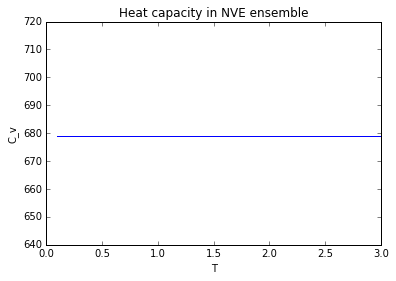

In [27]:
Heat_capacity_NVE(var_E_kin,exp_E_kin,N);